<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Scalar Field Collapse

## Authors: Leonardo Werneck & Zachariah B. Etienne

## This module sets up spherically symmetric, time-symmetric initial data for a scalar field collapse in Spherical coordinates, as [documented in this NRPy+ module](Tutorial-ADM_Initial_Data-ScalarField.ipynb) (the initial data is shown to satisfy the Hamiltonian constraint [in this tutorial module](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_ScalarField_initial_data.ipynb)), which is then evolved forward in time. The aim is to reproduce the results from [Akbarian & Choptuik (2014)]( https://arxiv.org/pdf/1508.01614.pdf)  and [Baumgarte (2018)](https://arxiv.org/abs/1807.10342) (which used a similar approach), demonstrating that the Hamiltonian constraint violation during the simulation also converges to zero with increasing numerical resolution.

### **Results from this tutorial notebook have been used in the paper [Werneck *et al.* (2021)](https://arxiv.org/pdf/2106.06553.pdf)**

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data.</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate BSSN RHS expressions.</font>
    1. Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
    1. <font color='green'>Apply constraints on conformal 3-metric: $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$</font>
1. At the end of each iteration in time, output the <font color='green'>Hamiltonian constraint violation</font>.
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

## References

* [Akbarian & Choptuik (2015)](https://arxiv.org/pdf/1508.01614.pdf) (Useful to understand the theoretical framework)
* [Baumgarte (2018)](https://arxiv.org/pdf/1807.10342.pdf) (Useful to understand the theoretical framework)
* [Baumgarte & Shapiro's Numerical Relativity](https://books.google.com.br/books/about/Numerical_Relativity.html?id=dxU1OEinvRUC&redir_esc=y): Section 6.2.2 (Useful to understand how to solve the Hamiltonian constraint)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

1. [Step 1](#nrpy_core) Set core NRPy+ parameters for numerical grids and reference metric
    1. [Step 1.a](#cfl) Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep
1. [Step 2](#initial_data) Set up ADM initial data for the Scalar Field 
1. [Step 3](#adm_id_spacetime) Convert ADM initial data to BSSN-in-curvilinear coordinates
1. [Step 4](#bssn) Output C code for BSSN spacetime evolution
    1. [Step 4.a](#bssnrhs) Set up the BSSN and ScalarField right-hand-side (RHS) expressions, and add the *rescaled* $T^{\mu\nu}$ source terms
    1. [Step 4.b](#hamconstraint) Output the Hamiltonian constraint
    1. [Step 4.c](#enforce3metric) Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint
    1. [Step 4.d](#ccodegen) Generate C code kernels for BSSN expressions, in parallel if possible
    1. [Step 4.e](#cparams_rfm_and_domainsize) Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h`
1. [Step 5](#bc_functs) Set up boundary condition functions for chosen singular, curvilinear coordinate system
1. [Step 6](#main_ccode) The main C code: `ScalarFieldCollapse_Playground.c`
1. [Step 7](#visualization) Visualization
    1. [Step 7.a](#install_download) Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded
    1. [Step 7.b](#movie_dynamics) Dynamics of the solution
        1. [Step 7.b.i](#genimages) Generate images for visualization animation
        1. [Step 7.b.ii](#gemnvideo) Generate visualization animation
    1. [Step 7.c](#convergence) Convergence of constraint violation
1. [Step 8](#output_to_pdf) Output this module as $\LaTeX$-formatted PDF file

<a id='nrpy_core'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric  \[Back to [top](#toc)\]
$$\label{nrpy_core}$$

In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import lhrh,outputC,outCfunction  # NRPy+: Core C code output module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import sympy as sp               # SymPy: The Python computer algebra package upon which NRPy+ depends
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions

# Step P2: Create C code output directory:
Ccodesdir = os.path.join("BSSN_ScalarFieldCollapse_Ccodes")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
# !rm -r ScalarWaveCurvilinear_Playground_Ccodes
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesdir,"output")
cmd.mkdir(outdir)

# Step 1: Set the spatial dimension parameter
#         to three this time, and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "Spherical"

# Step 2.a: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.
domain_size     = 32

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.2 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05# If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.b: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 4        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.
CFL_FACTOR= 0.5

# Set the lapse & shift conditions
LapseCondition  = "OnePlusLog"
ShiftCondition  = "GammaDriving2ndOrder_Covariant"

# Step 3: Generate Runge-Kutta-based (RK-based) timestepping code.
#       As described above the Table of Contents, this is a 3-step process:
#       3.A: Evaluate RHSs (RHS_string)
#       3.B: Apply boundary conditions (post_RHS_string, pt 1)
#       3.C: Enforce det(gammabar) = det(gammahat) constraint (post_RHS_string, pt 2)
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))
MoL.MoL_C_Code_Generation(RK_method,
    RHS_string      = """
Ricci_eval(&rfmstruct, &params, RK_INPUT_GFS, auxevol_gfs);
rhs_eval(&rfmstruct, &params, auxevol_gfs, RK_INPUT_GFS, RK_OUTPUT_GFS);""",
    post_RHS_string = """
apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_OUTPUT_GFS);
enforce_detgammahat_constraint(&rfmstruct, &params,                     RK_OUTPUT_GFS);\n""",
    outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))

# Step 4: Set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Step 5: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

# Step 6: Copy SIMD/SIMD_intrinsics.h to $Ccodesdir/SIMD/SIMD_intrinsics.h
cmd.mkdir(os.path.join(Ccodesdir,"SIMD"))
shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesdir,"SIMD/"))

# Step 7: Impose spherical symmetry by demanding that all
#         derivatives in the angular directions vanish
par.set_parval_from_str("indexedexp::symmetry_axes","12")

<a id='cfl'></a>

## Step 1.a: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to the scalar wave equation to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [2]:
# Output the find_timestep() function to a C file.
rfm.out_timestep_func_to_file(os.path.join(Ccodesdir,"find_timestep.h"))

<a id='initial_data'></a>

# Step 2: Set up ADM initial data for the Scalar Field \[Back to [top](#toc)\]
$$\label{initial_data}$$

As documented [in the scalar field Gaussian pulse initial data NRPy+ tutorial notebook](TTutorial-ADM_Initial_Data-ScalarField.ipynb), we will now set up the scalar field initial data, storing the densely-sampled result to file.

The initial data function `ScalarField_InitialData` requires `SciPy`, so let's make sure it's installed.

In [3]:
!pip install scipy numpy > /dev/null

Next call the `ScalarField_InitialData()` function from the [ScalarField/ScalarField_InitialData.py](../edit/ScalarField/ScalarField_InitialData.py) NRPy+ module (see the [tutorial notebook](Tutorial-ADM_Initial_Data-ScalarField.ipynb)).

In [4]:
# Step 2.a: Import necessary Python and NRPy+ modules
import ScalarField.ScalarField_InitialData as sfid

# Step 2.b: Set the initial data parameters
outputfilename  = os.path.join(outdir,"SFID.txt")
ID_Family       = "Gaussian_pulse"
pulse_amplitude = 0.4
pulse_center    = 0
pulse_width     = 1
Nr              = 30000
rmax            = domain_size*1.1

# Step 2.c: Generate the initial data
sfid.ScalarField_InitialData(outputfilename,ID_Family,
                             pulse_amplitude,pulse_center,pulse_width,Nr,rmax)

# Step 2.d: Generate the needed C code
sfid.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(Ccodesdir=Ccodesdir)

Generated the ADM initial data for the gravitational collapse 
of a massless scalar field in Spherical coordinates.

Type of initial condition: Scalar field: "Gaussian" Shell
                         ADM quantities: Time-symmetric
                        Lapse condition: Pre-collapsed
Parameters: amplitude         = 0.4,
            center            = 0,
            width             = 1,
            domain size       = 35.2,
            number of points  = 30000,
            Initial data file = BSSN_ScalarFieldCollapse_Ccodes/output/SFID.txt.

Output C function ID_scalarfield_ADM_quantities() to file BSSN_ScalarFieldCollapse_Ccodes/ID_scalarfield_ADM_quantities.h
Output C function ID_scalarfield_spherical() to file BSSN_ScalarFieldCollapse_Ccodes/ID_scalarfield_spherical.h
Output C function ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2() to file BSSN_ScalarFieldCollapse_Ccodes/ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2.h
Output C function ID_scalarfield() to file BSSN_ScalarFieldCollaps

<a id='adm_id_spacetime'></a>

# Step 3: Convert ADM initial data to BSSN-in-curvilinear coordinates \[Back to [top](#toc)\]
$$\label{adm_id_spacetime}$$

This is an automated process, taken care of by [`BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear`](../edit/BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py), and documented [in this tutorial notebook](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).

In [5]:
import BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear as AtoBnum
AtoBnum.Convert_Spherical_or_Cartesian_ADM_to_BSSN_curvilinear("Spherical","ID_scalarfield_ADM_quantities",
                                                               Ccodesdir=Ccodesdir,loopopts="")

Output C function ID_BSSN_lambdas() to file BSSN_ScalarFieldCollapse_Ccodes/ID_BSSN_lambdas.h
Output C function ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs() to file BSSN_ScalarFieldCollapse_Ccodes/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h
Output C function ID_BSSN__ALL_BUT_LAMBDAs() to file BSSN_ScalarFieldCollapse_Ccodes/ID_BSSN__ALL_BUT_LAMBDAs.h


<a id='bssn'></a>

# Step 4: Output C code for BSSN spacetime evolution \[Back to [top](#toc)\]
$$\label{bssn}$$

<a id='bssnrhs'></a>

## Step 4.a: Set up the BSSN and ScalarField right-hand-side (RHS) expressions, and add the *rescaled* $T^{\mu\nu}$ source terms \[Back to [top](#toc)\]
$$\label{bssnrhs}$$

`BSSN.BSSN_RHSs()` sets up the RHSs assuming a spacetime vacuum: $T^{\mu\nu}=0$. (This might seem weird, but remember that, for example, *spacetimes containing only single or binary black holes are vacuum spacetimes*.) Here, using the [`BSSN.BSSN_stress_energy_source_terms`](../edit/BSSN/BSSN_stress_energy_source_terms.py) ([**tutorial**](Tutorial-BSSN_stress_energy_source_terms.ipynb)) NRPy+ module, we add the $T^{\mu\nu}$ source terms to these equations.

In [6]:
import time
import BSSN.BSSN_RHSs as rhs
import BSSN.BSSN_gauge_RHSs as gaugerhs
par.set_parval_from_str("BSSN.BSSN_gauge_RHSs::LapseEvolutionOption", LapseCondition)
par.set_parval_from_str("BSSN.BSSN_gauge_RHSs::ShiftEvolutionOption", ShiftCondition)

print("Generating symbolic expressions for BSSN RHSs...")
start = time.time()
# Enable rfm_precompute infrastructure, which results in
#   BSSN RHSs that are free of transcendental functions,
#   even in curvilinear coordinates, so long as
#   ConformalFactor is set to "W" (default).
cmd.mkdir(os.path.join(Ccodesdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(Ccodesdir,"rfm_files/"))

# Evaluate BSSN + BSSN gauge RHSs with rfm_precompute enabled:
import BSSN.BSSN_quantities as Bq
par.set_parval_from_str("BSSN.BSSN_quantities::LeaveRicciSymbolic","True")

rhs.BSSN_RHSs()

# Evaluate the Scalar Field RHSs
import ScalarField.ScalarField_RHSs as sfrhs
sfrhs.ScalarField_RHSs()

# Compute ScalarField T^{\mu\nu}
# Compute the scalar field energy-momentum tensor
import ScalarField.ScalarField_Tmunu as sfTmunu
sfTmunu.ScalarField_Tmunu()
T4UU = sfTmunu.T4UU

import BSSN.BSSN_stress_energy_source_terms as Bsest
Bsest.BSSN_source_terms_for_BSSN_RHSs(T4UU)
rhs.trK_rhs += Bsest.sourceterm_trK_rhs
for i in range(DIM):
    # Needed for Gamma-driving shift RHSs:
    rhs.Lambdabar_rhsU[i] += Bsest.sourceterm_Lambdabar_rhsU[i]
    # Needed for BSSN RHSs:
    rhs.lambda_rhsU[i]    += Bsest.sourceterm_lambda_rhsU[i]
    for j in range(DIM):
        rhs.a_rhsDD[i][j] += Bsest.sourceterm_a_rhsDD[i][j]

gaugerhs.BSSN_gauge_RHSs()

# We use betaU as our upwinding control vector:
Bq.BSSN_basic_tensors()
betaU = Bq.betaU

import BSSN.Enforce_Detgammahat_Constraint as EGC
enforce_detg_constraint_symb_expressions = EGC.Enforce_Detgammahat_Constraint_symb_expressions()

# Next compute Ricci tensor
par.set_parval_from_str("BSSN.BSSN_quantities::LeaveRicciSymbolic","False")
Bq.RicciBar__gammabarDD_dHatD__DGammaUDD__DGammaU()

# Now register the Hamiltonian as a gridfunction.
H = gri.register_gridfunctions("AUX","H")

# Then define the Hamiltonian constraint and output the optimized C code.
import BSSN.BSSN_constraints as bssncon
bssncon.BSSN_constraints(add_T4UUmunu_source_terms=False)
Bsest.BSSN_source_terms_for_BSSN_constraints(T4UU)
bssncon.H += Bsest.sourceterm_H

# Add Kreiss-Oliger dissipation
diss_strength = par.Cparameters("REAL","ScalarFieldCollapse",["diss_strength"],0.1)

alpha_dKOD   = ixp.declarerank1("alpha_dKOD")
cf_dKOD      = ixp.declarerank1("cf_dKOD")
trK_dKOD     = ixp.declarerank1("trK_dKOD")
sf_dKOD      = ixp.declarerank1("sf_dKOD")
sfM_dKOD     = ixp.declarerank1("sfM_dKOD")
betU_dKOD    = ixp.declarerank2("betU_dKOD","nosym")
vetU_dKOD    = ixp.declarerank2("vetU_dKOD","nosym")
lambdaU_dKOD = ixp.declarerank2("lambdaU_dKOD","nosym")
aDD_dKOD     = ixp.declarerank3("aDD_dKOD","sym01")
hDD_dKOD     = ixp.declarerank3("hDD_dKOD","sym01")

for k in range(3):
    gaugerhs.alpha_rhs += diss_strength*alpha_dKOD[k]*rfm.ReU[k]
    rhs.cf_rhs         += diss_strength*   cf_dKOD[k]*rfm.ReU[k]
    rhs.trK_rhs        += diss_strength*  trK_dKOD[k]*rfm.ReU[k]
    sfrhs.sf_rhs       += diss_strength*   sf_dKOD[k]*rfm.ReU[k]
    sfrhs.sfM_rhs      += diss_strength*  sfM_dKOD[k]*rfm.ReU[k]
    for i in range(3):
        if "2ndOrder" in ShiftCondition:
            gaugerhs.bet_rhsU[i] += diss_strength*   betU_dKOD[i][k]*rfm.ReU[k]
        gaugerhs.vet_rhsU[i]     += diss_strength*   vetU_dKOD[i][k]*rfm.ReU[k]
        rhs.lambda_rhsU[i]       += diss_strength*lambdaU_dKOD[i][k]*rfm.ReU[k]
        for j in range(3):
            rhs.a_rhsDD[i][j] += diss_strength*aDD_dKOD[i][j][k]*rfm.ReU[k]
            rhs.h_rhsDD[i][j] += diss_strength*hDD_dKOD[i][j][k]*rfm.ReU[k]

# Now that we are finished with all the rfm hatted
#           quantities in generic precomputed functional
#           form, let's restore them to their closed-
#           form expressions.
par.set_parval_from_str("reference_metric::enable_rfm_precompute","False") # Reset to False to disable rfm_precompute.
rfm.ref_metric__hatted_quantities()
end = time.time()
print("(BENCH) Finished BSSN symbolic expressions in "+str(end-start)+" seconds.")

def BSSN_plus_ScalarField_RHSs():
    print("Generating C code for BSSN RHSs in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
    start = time.time()

    # Construct the left-hand sides and right-hand-side expressions for all BSSN RHSs
    lhs_names = [        "alpha",       "cf",       "trK",         "sf",         "sfM"   ]
    rhs_exprs = [gaugerhs.alpha_rhs, rhs.cf_rhs, rhs.trK_rhs, sfrhs.sf_rhs, sfrhs.sfM_rhs]
    for i in range(3):
        lhs_names.append(        "betU"+str(i))
        rhs_exprs.append(gaugerhs.bet_rhsU[i])
        lhs_names.append(   "lambdaU"+str(i))
        rhs_exprs.append(rhs.lambda_rhsU[i])
        lhs_names.append(        "vetU"+str(i))
        rhs_exprs.append(gaugerhs.vet_rhsU[i])
        for j in range(i,3):
            lhs_names.append(   "aDD"+str(i)+str(j))
            rhs_exprs.append(rhs.a_rhsDD[i][j])
            lhs_names.append(   "hDD"+str(i)+str(j))
            rhs_exprs.append(rhs.h_rhsDD[i][j])

    # Sort the lhss list alphabetically, and rhss to match.
    #   This ensures the RHSs are evaluated in the same order
    #   they're allocated in memory:
    lhs_names,rhs_exprs = [list(x) for x in zip(*sorted(zip(lhs_names,rhs_exprs), key=lambda pair: pair[0]))]

    # Declare the list of lhrh's
    BSSN_evol_rhss = []
    for var in range(len(lhs_names)):
        BSSN_evol_rhss.append(lhrh(lhs=gri.gfaccess("rhs_gfs",lhs_names[var]),rhs=rhs_exprs[var]))

    # Set up the C function for the BSSN RHSs
    desc="Evaluate the BSSN RHSs"
    name="rhs_eval"
    outCfunction(
        outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
        params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                      const REAL *restrict auxevol_gfs,const REAL *restrict in_gfs,REAL *restrict rhs_gfs""",
        body     = fin.FD_outputC("returnstring",BSSN_evol_rhss, params="outCverbose=False,enable_SIMD=True",
                                  upwindcontrolvec=betaU),
        loopopts = "InteriorPoints,enable_SIMD,enable_rfm_precompute")
    end = time.time()
    print("(BENCH) Finished BSSN_RHS C codegen in " + str(end - start) + " seconds.")

def Ricci():
    print("Generating C code for Ricci tensor in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
    start = time.time()
    desc="Evaluate the Ricci tensor"
    name="Ricci_eval"
    outCfunction(
        outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
        params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                      const REAL *restrict in_gfs,REAL *restrict auxevol_gfs""",
        body     = fin.FD_outputC("returnstring",
                                  [lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD00"),rhs=Bq.RbarDD[0][0]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD01"),rhs=Bq.RbarDD[0][1]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD02"),rhs=Bq.RbarDD[0][2]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD11"),rhs=Bq.RbarDD[1][1]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD12"),rhs=Bq.RbarDD[1][2]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD22"),rhs=Bq.RbarDD[2][2])],
                                   params="outCverbose=False,enable_SIMD=True"),
        loopopts = "InteriorPoints,enable_SIMD,enable_rfm_precompute")
    end = time.time()
    print("(BENCH) Finished Ricci C codegen in " + str(end - start) + " seconds.")

Generating symbolic expressions for BSSN RHSs...
(BENCH) Finished BSSN symbolic expressions in 9.12996506690979 seconds.


<a id='hamconstraint'></a>

## Step 4.b: Output the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{hamconstraint}$$

Next output the C code for evaluating the Hamiltonian constraint [(**Tutorial**)](Tutorial-BSSN_constraints.ipynb). In the absence of numerical error, this constraint should evaluate to zero. However it does not due to numerical (typically truncation and roundoff) error. We will therefore measure the Hamiltonian constraint violation to gauge the accuracy of our simulation, and, ultimately determine whether errors are dominated by numerical finite differencing (truncation) error as expected.

In [7]:
def Hamiltonian():
    start = time.time()
    print("Generating optimized C code for Hamiltonian constraint. May take a while, depending on CoordSystem.")
    # Set up the C function for the Hamiltonian RHS
    desc="Evaluate the Hamiltonian constraint"
    name="Hamiltonian_constraint"
    outCfunction(
        outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
        params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                      REAL *restrict in_gfs, REAL *restrict auxevol_gfs, REAL *restrict aux_gfs""",
        body     = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs", "H"), rhs=bssncon.H),
                                  params="outCverbose=False"),
        loopopts = "InteriorPoints,enable_rfm_precompute")

    end = time.time()
    print("(BENCH) Finished Hamiltonian C codegen in " + str(end - start) + " seconds.")

<a id='enforce3metric'></a>

## Step 4.c: Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint \[Back to [top](#toc)\]
$$\label{enforce3metric}$$

Then enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658)), as [documented in the corresponding NRPy+ tutorial notebook](Tutorial-BSSN_enforcing_determinant_gammabar_equals_gammahat_constraint.ipynb)

Applying curvilinear boundary conditions should affect the initial data at the outer boundary, and will in general cause the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint to be violated there. Thus after we apply these boundary conditions, we must always call the routine for enforcing the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint:

In [8]:
def gammadet():
    start = time.time()
    print("Generating optimized C code for gamma constraint. May take a while, depending on CoordSystem.")

    # Set up the C function for the det(gammahat) = det(gammabar)
    EGC.output_Enforce_Detgammahat_Constraint_Ccode(Ccodesdir,exprs=enforce_detg_constraint_symb_expressions)
    end = time.time()
    print("(BENCH) Finished gamma constraint C codegen in " + str(end - start) + " seconds.")

<a id='ccodegen'></a>

## Step 4.d: Generate C code kernels for BSSN expressions, in parallel if possible \[Back to [top](#toc)\]
$$\label{ccodegen}$$

In [9]:
# Step 4.d: C code kernel generation
# Step 4.d.i: Create a list of functions we wish to evaluate in parallel
funcs = [BSSN_plus_ScalarField_RHSs,Ricci,Hamiltonian,gammadet]

try:
    import platform
    os_name = platform.system() # Linux, Darwin, or Windows
    # Step 2.d: Import the multiprocessing module.
    if os_name == 'Windows':
        # It's a mess to get working in Windows, so we don't bother. :/
        #  https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac
        raise Exception("Parallel codegen currently not available in certain environments, e.g., Windows")
    elif os_name == "Darwin":
        # On Mac OS multiprocessing does not work as expected in Jupyter
        # notebooks, so we use multiprocess instead
        try:
            import multiprocess as mp
        except:
            error = "Could not load multiprocess. Please install it (e.g., `$ pip install multiprocess`) and try running this notebook again."
            raise ImportError(error)
    elif os_name == "Linux":
        # On Linux using multiprocessing does not seem to be a problem
        import multiprocessing as mp
    else:
        raise Exception(f"Unknown system {os_name}. Reverting to serial code generation.")

    # Step 4.d.iii: Define master function for parallelization.
    #           Note that lambdifying this doesn't work in Python 3
    def master_func(arg):
        funcs[arg]()

    # Step 4.d.iv: Evaluate list of functions in parallel if possible;
    #           otherwise fallback to serial evaluation:
    pool = mp.Pool()
    pool.map(master_func,range(len(funcs)))
except:
    # Steps 4.d.iii-4.d.v, alternate: As fallback, evaluate functions in serial.
    for func in funcs:
        func()

Generating C code for BSSN RHSs in Spherical coordinates.Generating C code for Ricci tensor in Spherical coordinates.
Generating optimized C code for gamma constraint. May take a while, depending on CoordSystem.
Generating optimized C code for Hamiltonian constraint. May take a while, depending on CoordSystem.

Output C function enforce_detgammahat_constraint() to file BSSN_ScalarFieldCollapse_Ccodes/enforce_detgammahat_constraint.h
(BENCH) Finished gamma constraint C codegen in 0.20664405822753906 seconds.
Output C function Ricci_eval() to file BSSN_ScalarFieldCollapse_Ccodes/Ricci_eval.h
(BENCH) Finished Ricci C codegen in 15.17826509475708 seconds.
Output C function rhs_eval() to file BSSN_ScalarFieldCollapse_Ccodes/rhs_eval.h
(BENCH) Finished BSSN_RHS C codegen in 17.862242221832275 seconds.
Output C function Hamiltonian_constraint() to file BSSN_ScalarFieldCollapse_Ccodes/Hamiltonian_constraint.h
(BENCH) Finished Hamiltonian C codegen in 24.206409215927124 seconds.


<a id='cparams_rfm_and_domainsize'></a>

## Step 4.e: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [10]:
# Step 4.e.i: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

# Step 4.e.ii: Set free_parameters.h
# Output to $Ccodesdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)

# Step 4.e.iii: Generate set_Nxx_dxx_invdx_params__and__xx.h:
rfm.set_Nxx_dxx_invdx_params__and__xx_h(Ccodesdir)

# Step 4.e.iv: Generate xx_to_Cart.h, which contains xx_to_Cart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
rfm.xx_to_Cart_h("xx_to_Cart","./set_Cparameters.h",os.path.join(Ccodesdir,"xx_to_Cart.h"))

# Step 4.e.v: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

<a id='bc_functs'></a>

# Step 5: Set up boundary condition functions for chosen singular, curvilinear coordinate system \[Back to [top](#toc)\]
$$\label{bc_functs}$$

Next apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb).

In [11]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),Cparamspath=os.path.join("../"))

Wrote to file "BSSN_ScalarFieldCollapse_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved parity: ( aDD00:4, aDD01:5, aDD02:6, aDD11:7, aDD12:8, aDD22:9,
    alpha:0, betU0:1, betU1:2, betU2:3, cf:0, hDD00:4, hDD01:5, hDD02:6,
    hDD11:7, hDD12:8, hDD22:9, lambdaU0:1, lambdaU1:2, lambdaU2:3, sf:0,
    sfM:0, trK:0, vetU0:1, vetU1:2, vetU2:3 )
Auxiliary parity: ( H:0 )
AuxEvol parity: ( RbarDD00:4, RbarDD01:5, RbarDD02:6, RbarDD11:7,
    RbarDD12:8, RbarDD22:9 )
Wrote to file "BSSN_ScalarFieldCollapse_Ccodes/boundary_conditions/EigenCoord_Cart_to_xx.h"


<a id='main_ccode'></a>

# Step 6: The main C code: `ScalarFieldCollapse_Playground.c` \[Back to [top](#toc)\]
$$\label{main_ccode}$$

In [12]:
# Part P0: Define REAL, set the number of ghost cells NGHOSTS (from NRPy+'s FD_CENTDERIVS_ORDER),
#          and set the CFL_FACTOR (which can be overwritten at the command line)

with open(os.path.join(Ccodesdir,"ScalarFieldCollapse_Playground_REAL__NGHOSTS__CFL_FACTOR.h"), "w") as file:
    file.write("""
// Part P0.a: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
#define NGHOSTS """+str(int(FD_order/2)+1)+"""
// Part P0.b: Set the numerical precision (REAL) to double, ensuring all floating point
//            numbers are stored to at least ~16 significant digits
#define REAL """+REAL+"""
// Part P0.c: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
REAL CFL_FACTOR = """+str(CFL_FACTOR)+"""; // Set the CFL Factor. Can be overwritten at command line.\n""")

In [13]:
%%writefile $Ccodesdir/ScalarFieldCollapse_Playground.c

// Step P0: Define REAL and NGHOSTS; and declare CFL_FACTOR. This header is generated in NRPy+.
#include "ScalarFieldCollapse_Playground_REAL__NGHOSTS__CFL_FACTOR.h"

#include "rfm_files/rfm_struct__declare.h"

#include "declare_Cparameters_struct.h"

// All SIMD intrinsics used in SIMD-enabled C code loops are defined here:
#include "SIMD/SIMD_intrinsics.h"

// Step P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"
#include "stdint.h" // Needed for Windows GCC 6.x compatibility
#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif
#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif
#define wavespeed 1.0 // Set CFL-based "wavespeed" to 1.0.
#define alpha_threshold (2e-3) // Value below which we rule gravitational collapse has happened

// Step P2: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i"
//           (all other indices held to a fixed value) are consecutive in memory, where
//           consecutive values of "j" (fixing all other indices) are separated by
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX4ptS(g,idx) ( (idx) + (Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) * (g) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

// Step P3: Set UUGF and VVGF macros, as well as xx_to_Cart()
#include "boundary_conditions/gridfunction_defines.h"

// Step P4: Set xx_to_Cart(const paramstruct *restrict params,
//                     REAL *restrict xx[3],
//                     const int i0,const int i1,const int i2,
//                     REAL xCart[3]),
//           which maps xx->Cartesian via
//    {xx[0][i0],xx[1][i1],xx[2][i2]}->{xCart[0],xCart[1],xCart[2]}
#include "xx_to_Cart.h"

// Step P5: Defines set_Nxx_dxx_invdx_params__and__xx(const int EigenCoord, const int Nxx[3],
//                                       paramstruct *restrict params, REAL *restrict xx[3]),
//          which sets params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for
//          the chosen Eigen-CoordSystem if EigenCoord==1, or
//          CoordSystem if EigenCoord==0.
#include "set_Nxx_dxx_invdx_params__and__xx.h"

// Step P6: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "boundary_conditions/CurviBC_include_Cfunctions.h"

// Step P7: Implement the algorithm for upwinding.
//          *NOTE*: This upwinding is backwards from
//          usual upwinding algorithms, because the
//          upwinding control vector in BSSN (the shift)
//          acts like a *negative* velocity.
//#define UPWIND_ALG(UpwindVecU) UpwindVecU > 0.0 ? 1.0 : 0.0

// Step P8: Include function for enforcing detgammabar constraint.
#include "enforce_detgammahat_constraint.h"

// Step P9: Find the CFL-constrained timestep
#include "find_timestep.h"

// Step P10: Declare initial data input struct:
//           stores data from initial data solver,
//           so they can be put on the numerical grid.
typedef struct __ID_inputs {
    int interp_stencil_size;
    int numlines_in_file;
    REAL *r_arr,*sf_arr,*psi4_arr,*alpha_arr;
} ID_inputs;

// Part P11: Declare all functions for setting up ScalarField initial data.
/* Routines to interpolate the ScalarField solution and convert to ADM & T^{munu}: */
#include "../ScalarField/ScalarField_interp.h"
#include "ID_scalarfield_ADM_quantities.h"
#include "ID_scalarfield_spherical.h"
#include "ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2.h"
#include "ID_scalarfield.h"

/* Next perform the basis conversion and compute all needed BSSN quantities */
#include "ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN_lambdas.h"

// Step P12: Set the generic driver function for setting up BSSN initial data
void initial_data(const paramstruct *restrict params,const bc_struct *restrict bcstruct,
                  const rfm_struct *restrict rfmstruct,
                  REAL *restrict xx[3], REAL *restrict auxevol_gfs, REAL *restrict in_gfs) {
#include "set_Cparameters.h"

    // Step 1: Set up ScalarField initial data
    // Step 1.a: Read ScalarField initial data from data file
    // Open the data file:
    char filename[100];
    sprintf(filename,"./SFID.txt");
    FILE *fp = fopen(filename, "r");
    if (fp == NULL) {
        fprintf(stderr,"ERROR: could not open file %s\n",filename);
        exit(1);
    }
    // Count the number of lines in the data file:
    int numlines_in_file = count_num_lines_in_file(fp);
    // Allocate space for all data arrays:
    REAL *r_arr     = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *sf_arr    = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *psi4_arr  = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *alpha_arr = (REAL *)malloc(sizeof(REAL)*numlines_in_file);

    // Read from the data file, filling in arrays
    // read_datafile__set_arrays() may be found in ScalarField/ScalarField_interp.h
    if(read_datafile__set_arrays(fp,r_arr,sf_arr,psi4_arr,alpha_arr) == 1) {
        fprintf(stderr,"ERROR WHEN READING FILE %s!\n",filename);
        exit(1);
    }
    fclose(fp);

    const int interp_stencil_size = 12;
    ID_inputs SF_in;
    SF_in.interp_stencil_size = interp_stencil_size;
    SF_in.numlines_in_file    = numlines_in_file;
    SF_in.r_arr               = r_arr;
    SF_in.sf_arr              = sf_arr;
    SF_in.psi4_arr            = psi4_arr;
    SF_in.alpha_arr           = alpha_arr;

    // Step 1.b: Interpolate data from data file to set BSSN gridfunctions
    ID_scalarfield(params,xx,SF_in, in_gfs);
    ID_BSSN__ALL_BUT_LAMBDAs(params,xx,SF_in, in_gfs);
    apply_bcs_curvilinear(params, bcstruct, NUM_EVOL_GFS, evol_gf_parity, in_gfs);
    enforce_detgammahat_constraint(rfmstruct, params,                   in_gfs);
    ID_BSSN_lambdas(params, xx, in_gfs);
    apply_bcs_curvilinear(params, bcstruct, NUM_EVOL_GFS, evol_gf_parity, in_gfs);
    enforce_detgammahat_constraint(rfmstruct, params,                   in_gfs);

    free(r_arr);
    free(sf_arr);
    free(psi4_arr);
    free(alpha_arr);
}

// Step P11: Declare function for evaluating Hamiltonian constraint (diagnostic)
#include "Hamiltonian_constraint.h"

// Step P12: Declare rhs_eval function, which evaluates BSSN RHSs
#include "rhs_eval.h"

// Step P13: Declare Ricci_eval function, which evaluates Ricci tensor
#include "Ricci_eval.h"

//#include "NRPyCritCol_regridding.h"

REAL rho_max = 0.0;

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
// Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
//         Lines timestepping algorithm, and output periodic simulation diagnostics
// Step 3.a: Output 2D data file periodically, for visualization
// Step 3.b: Step forward one timestep (t -> t+dt) in time using
//           chosen RK-like MoL timestepping algorithm
// Step 3.c: If t=t_final, output conformal factor & Hamiltonian
//           constraint violation to 1D data file
// Step 3.d: Progress indicator printing to stderr
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"

    // Step 0a: Read command-line input, error out if nonconformant
    if((argc != 4 && argc != 5) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < 2 || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./ScalarFieldCollapse_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    if(argc == 5) {
        CFL_FACTOR = strtod(argv[4],NULL);
        if(CFL_FACTOR > 0.5 && atoi(argv[3])!=2) {
            fprintf(stderr,"WARNING: CFL_FACTOR was set to %e, which is > 0.5.\n",CFL_FACTOR);
            fprintf(stderr,"         This will generally only be stable if the simulation is purely axisymmetric\n");
            fprintf(stderr,"         However, Nx2 was set to %d>2, which implies a non-axisymmetric simulation\n",atoi(argv[3]));
        }
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }

    // Step 0c: Set free parameters, overwriting Cparameters defaults
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"

   // Step 0d: Uniform coordinate grids are stored to *xx[3]
    REAL *xx[3];
    // Step 0d.i: Set bcstruct
    bc_struct bcstruct;
    {
        int EigenCoord = 1;
        // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
        //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
        //             chosen Eigen-CoordSystem.
        set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);
        // Step 0d.iii: Set Nxx_plus_2NGHOSTS_tot
#include "set_Cparameters-nopointer.h"
        const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
        // Step 0e: Find ghostzone mappings; set up bcstruct
#include "boundary_conditions/driver_bcstruct.h"
        // Step 0e.i: Free allocated space for xx[][] array
        for(int i=0;i<3;i++) free(xx[i]);
    }

    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    int EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

    // Step 0g: Set all C parameters "blah" for params.blah, including
    //          Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.
#include "set_Cparameters-nopointer.h"
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Step 0h: Time coordinate parameters
    REAL t_final = 16.0; /* Final time is set so that at t=t_final,
                          * data at the origin have not been corrupted
                          * by the approximate outer boundary condition */

    // Step 0i: Set timestep based on smallest proper distance between gridpoints and CFL factor
    REAL dt = find_timestep(&params, xx);
    //fprintf(stderr,"# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of points in time.
                                             // Add 0.5 to account for C rounding down
                                             // typecasts to integers.
    int output_every_N = 20;//(int)((REAL)N_final/800.0);
    if(output_every_N == 0) output_every_N = 1;

    // Step 0j: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
    //              This is a limitation of the RK method. You are always welcome to declare & allocate
    //              additional gridfunctions by hand.
    if(NUM_AUX_GFS > NUM_EVOL_GFS) {
        fprintf(stderr,"Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
        fprintf(stderr,"       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
        exit(1);
    }

    // Step 0k: Allocate memory for gridfunctions
#include "MoLtimestepping/RK_Allocate_Memory.h"
    REAL *restrict auxevol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0l: Set up precomputed reference metric arrays
    // Step 0l.i: Allocate space for precomputed reference metric arrays.
#include "rfm_files/rfm_struct__malloc.h"

    // Step 0l.ii: Define precomputed reference metric arrays.
    {
    #include "set_Cparameters-nopointer.h"
    #include "rfm_files/rfm_struct__define.h"
    }

    // Step 1: Set up initial data to an exact solution
    initial_data(&params,&bcstruct, &rfmstruct, xx, auxevol_gfs, y_n_gfs);

    // Step 1b: Apply boundary conditions, as initial data
    //          are sometimes ill-defined in ghost zones.
    //          E.g., spherical initial data might not be
    //          properly defined at points where r=-1.
    apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS,evol_gf_parity, y_n_gfs);
    enforce_detgammahat_constraint(&rfmstruct, &params, y_n_gfs);

    // Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
#ifdef __linux__ // Use high-precision timer in Linux.
    struct timespec start, end;
    clock_gettime(CLOCK_REALTIME, &start);
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
    // http://www.cplusplus.com/reference/ctime/time/
    time_t start_timer,end_timer;
    time(&start_timer); // Resolution of one second...
#endif

    // Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
    //         Lines timestepping algorithm, and output periodic simulation diagnostics
    for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.

        // Step 3.a: Output 2D data file periodically, for visualization
        if(n%output_every_N == 0) {
            // Evaluate Hamiltonian constraint violation
            Hamiltonian_constraint(&rfmstruct, &params, y_n_gfs,auxevol_gfs, diagnostic_output_gfs);

            char filename[100];
            sprintf(filename,"out%d-%08d.txt",Nxx[0],n);
            const int i1mid=Nxx_plus_2NGHOSTS1/2;
            const int i2mid=Nxx_plus_2NGHOSTS2/2;
            FILE *fp = fopen(filename, "w");
            for( int i0=NGHOSTS;i0<Nxx_plus_2NGHOSTS0-NGHOSTS;i0++) {
                const int idx  = IDX3S(i0,i1mid,i2mid);
                const REAL xx0 = xx[0][i0];
                REAL xCart[3];
                xx_to_Cart(&params,xx,i0,i1mid,i2mid,xCart);
                const REAL rr = sqrt( xCart[0]*xCart[0] + xCart[1]*xCart[1] + xCart[2]*xCart[2] );
                fprintf(fp,"%e %e %e %e %e %e %e\n",xx0,rr,
                        y_n_gfs[IDX4ptS(SFGF,idx)],y_n_gfs[IDX4ptS(SFMGF,idx)],
                        y_n_gfs[IDX4ptS(ALPHAGF,idx)],y_n_gfs[IDX4ptS(CFGF,idx)],
                        log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
            }
            fclose(fp);
        }

        // Step 3.b: Step forward one timestep (t -> t+dt) in time using
        //           chosen RK-like MoL timestepping algorithm
#include "MoLtimestepping/RK_MoL.h"

        // Step 3.c: If t=t_final, output conformal factor & Hamiltonian
        //           constraint violation to 2D data file
        if(n==N_final-1) {
            // Evaluate Hamiltonian constraint violation
            Hamiltonian_constraint(&rfmstruct, &params, y_n_gfs,auxevol_gfs, diagnostic_output_gfs);
            char filename[100];
            sprintf(filename,"out%d.txt",Nxx[0]);
            FILE *out1D = fopen(filename, "w");
            const int i1mid=Nxx_plus_2NGHOSTS1/2;
            const int i2mid=Nxx_plus_2NGHOSTS2/2;
            for(int i0=NGHOSTS;i0<Nxx_plus_2NGHOSTS0-NGHOSTS;i0++) {
                REAL xCart[3];
                xx_to_Cart(&params,xx,i0,i1mid,i2mid,xCart);
                const REAL rr = sqrt( xCart[0]*xCart[0] + xCart[1]*xCart[1] + xCart[2]*xCart[2] );
                int idx = IDX3S(i0,i1mid,i2mid);
                fprintf(out1D,"%e %e\n",rr,log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
            }
            fclose(out1D);
        }

        // Step 3.d: Progress indicator printing to stderr

        // Step 3.d.i: Measure average time per iteration
#ifdef __linux__ // Use high-precision timer in Linux.
        clock_gettime(CLOCK_REALTIME, &end);
        const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
        time(&end_timer); // Resolution of one second...
        REAL time_in_ns = difftime(end_timer,start_timer)*1.0e9+0.5; // Round up to avoid divide-by-zero.
#endif
        const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)n) / 1.0e9;

        const int iterations_remaining = N_final - n;
        const REAL time_remaining_in_mins = s_per_iteration_avg * (REAL)iterations_remaining / 60.0;

        const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)n; // 4 RHS evals per gridpoint for RK4
        const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);


        // Step 3.d.ii: Output simulation progress to stderr
        if(n%10 == 0) {
            fprintf(stderr,"%c[2K", 27); // Clear the line
            fprintf(stderr,"It: %d t=%.2f dt=%.2e | %.1f%%; ETA %.0f s | t/h %.2f | gp/s %.2e\r",  // \r is carriage return, move cursor to the beginning of the line
                   n, n*dt, (double)dt, (double)(100.0 * (REAL)n / (REAL)N_final),
                   (double)time_remaining_in_mins*60, (double)(dt * 3600.0 / s_per_iteration_avg), (double)RHS_pt_evals_per_sec);
            fflush(stderr); // Flush the stderr buffer
        } // End progress indicator if(n % 10 == 0)
    } // End main loop to progress forward in time.
    fprintf(stderr,"\n"); // Clear the final line of output from progress indicator.

    // Step 4: Free all allocated memory
#include "rfm_files/rfm_struct__freemem.h"
#include "boundary_conditions/bcstruct_freemem.h"
#include "MoLtimestepping/RK_Free_Memory.h"
    free(auxevol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);

    return 0;
}

Writing BSSN_ScalarFieldCollapse_Ccodes/ScalarFieldCollapse_Playground.c


In [14]:
import os
import time
import cmdline_helper as cmd

print("Now compiling, should take ~10 seconds...\n")
start = time.time()
cmd.C_compile(os.path.join(Ccodesdir,"ScalarFieldCollapse_Playground.c"),
              os.path.join(outdir,"ScalarFieldCollapse_Playground"),compile_mode="optimized")
end = time.time()
print("(BENCH) Finished in "+str(end-start)+" seconds.\n")

# Change to output directory
os.chdir(outdir)
# Clean up existing output files
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("out*.png")
# Run executable

print(os.getcwd())
print("Now running, should take ~20 seconds...\n")
start = time.time()
cmd.Execute("ScalarFieldCollapse_Playground", "640 2 2 "+str(CFL_FACTOR),"out640.txt")
end = time.time()
print("(BENCH) Finished in "+str(end-start)+" seconds.\n")

# Return to root directory
os.chdir(os.path.join("../../"))

Now compiling, should take ~10 seconds...

Compiling executable...
(EXEC): Executing `gcc -std=gnu99 -Ofast -fopenmp -march=native -funroll-loops BSSN_ScalarFieldCollapse_Ccodes/ScalarFieldCollapse_Playground.c -o BSSN_ScalarFieldCollapse_Ccodes/output/ScalarFieldCollapse_Playground -lm`...
(BENCH): Finished executing in 8.370473861694336 seconds.
Finished compilation.
(BENCH) Finished in 8.386640071868896 seconds.

/Users/werneck/Codes/nrpytutorial/BSSN_ScalarFieldCollapse_Ccodes/output
Now running, should take ~20 seconds...

(EXEC): Executing `./ScalarFieldCollapse_Playground 640 2 2 0.5`...
It: 810 t=15.90 dt=1.96e-02 | 99.4%; ETA 0 s | t/h 3367.97 | gp/s 4.88e+0514e+14
(BENCH): Finished executing in 17.157500982284546 seconds.
(BENCH) Finished in 17.171742916107178 seconds.



<a id='visualization'></a>

# Step 7: Visualization \[Back to [top](#toc)\]
$$\label{visualization}$$

<a id='install_download'></a>

## Step 7.a: Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded \[Back to [top](#toc)\]
$$\label{install_download}$$ 

Note that if you are not running this within `mybinder`, but on a Windows system, `ffmpeg` must be installed using a separate package (on [this site](http://ffmpeg.org/)), or if running Jupyter within Anaconda, use the command: `conda install -c conda-forge ffmpeg`.

In [15]:
!pip install scipy > /dev/null

check_for_ffmpeg = !which ffmpeg >/dev/null && echo $?
if check_for_ffmpeg != ['0']:
    print("Couldn't find ffmpeg, so I'll download it.")
    # Courtesy https://johnvansickle.com/ffmpeg/
    !wget https://etienneresearch.com/ffmpeg-static-amd64-johnvansickle.tar.xz
    !tar Jxf ffmpeg-static-amd64-johnvansickle.tar.xz
    print("Copying ffmpeg to ~/.local/bin/. Assumes ~/.local/bin is in the PATH.")
    !mkdir ~/.local/bin/
    !cp ffmpeg-static-amd64-johnvansickle/ffmpeg ~/.local/bin/
    print("If this doesn't work, then install ffmpeg yourself. It should work fine on mybinder.")

<a id='movie_dynamics'></a>

## Step 7.b: Dynamics of the solution \[Back to [top](#toc)\]
$$\label{movie_dynamics}$$

<a id='genimages'></a>

### Step 7.b.i: Generate images for visualization animation \[Back to [top](#toc)\]
$$\label{genimages}$$ 

Here we loop through the data files output by the executable compiled and run in [the previous step](#mainc), generating a [png](https://en.wikipedia.org/wiki/Portable_Network_Graphics) image for each data file.

**Special thanks to Terrence Pierre Jacques. His work with the first versions of these scripts greatly contributed to the scripts as they exist below.**

In [16]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import glob
import sys
from matplotlib import animation

globby = glob.glob(os.path.join(outdir,'out640-00*.txt'))
file_list = []
for x in sorted(globby):
    file_list.append(x)

for filename in file_list:
    fig = plt.figure(figsize=(8,6))
    x,r,sf,sfM,alpha,cf,logH = np.loadtxt(filename).T #Transposed for easier unpacking

    ax  = fig.add_subplot(321)
    ax2 = fig.add_subplot(322)
    ax3 = fig.add_subplot(323)
    ax4 = fig.add_subplot(324)
    ax5 = fig.add_subplot(325)

    ax.set_title("Scalar field")
    ax.set_ylabel(r"$\varphi(t,r)$")
    ax.set_xlim(0,20)
    ax.set_ylim(-0.6,0.6)
    ax.plot(r,sf,'k-')
    ax.grid()

    ax2.set_title("Scalar field conjugate momentum")
    ax2.set_ylabel(r"$\Pi(t,r)$")
    ax2.set_xlim(0,20)
    ax2.set_ylim(-1,1)
    ax2.plot(r,sfM,'b-')
    ax2.grid()

    ax3.set_title("Lapse function")
    ax3.set_ylabel(r"$\alpha(t,r)$")
    ax3.set_xlim(0,20)
    ax3.set_ylim(0,1.02)
    ax3.plot(r,alpha,'r-')
    ax3.grid()

    ax4.set_title("Conformal factor")
    ax4.set_xlabel(r"$r$")
    ax4.set_ylabel(r"$W(t,r)$")
    ax4.set_xlim(0,20)
    ax4.set_ylim(0,1.02)
    ax4.plot(r,cf,'g-',label=("$p = 0.043149493$"))
    ax4.grid()

    ax5.set_title("Hamiltonian constraint violation")
    ax5.set_xlabel(r"$r$")
    ax5.set_ylabel(r"$\mathcal{H}(t,r)$")
    ax5.set_xlim(0,20)
    ax5.set_ylim(-16,0)
    ax5.plot(r,logH,'m-')
    ax5.grid()

    plt.tight_layout()
    savefig(filename+".png",dpi=150)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file "+filename+"\r")
    sys.stdout.flush()

<a id='genvideo'></a>

### Step 7.b.ii: Generate visualization animation \[Back to [top](#toc)\]
$$\label{genvideo}$$ 

In the following step, [ffmpeg](http://ffmpeg.org) is used to generate an [mp4](https://en.wikipedia.org/wiki/MPEG-4) video file, which can be played directly from this Jupyter notebook.

In [17]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##

# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation
from IPython.display import HTML
import matplotlib.image as mgimg

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)):
    img = mgimg.imread(file_list[i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save(os.path.join(outdir,'ScalarField_Collapse.mp4'), fps=5, dpi=150)

In [18]:
## VISUALIZATION ANIMATION, PART 3: Display movie as embedded HTML5 (see next cell) ##

# https://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook

In [19]:
# Embed video based on suggestion:
#  https://stackoverflow.com/questions/39900173/jupyter-notebook-html-cell-magic-with-python-variable
HTML("""
<video width="800" height="600" controls>
  <source src=\""""+os.path.join(outdir,"ScalarField_Collapse.mp4")+"""\" type="video/mp4">
</video>
""")

<a id='convergence'></a>

## Step 7.c: Convergence of constraint violation \[Back to [top](#toc)\]
$$\label{convergence}$$

(EXEC): Executing `./ScalarFieldCollapse_Playground 320 2 2 0.5`...
It: 400 t=15.71 dt=3.93e-02 | 98.3%; ETA 0 s | t/h 14137.17 | gp/s 5.12e+05
(BENCH): Finished executing in 4.3146653175354 seconds.


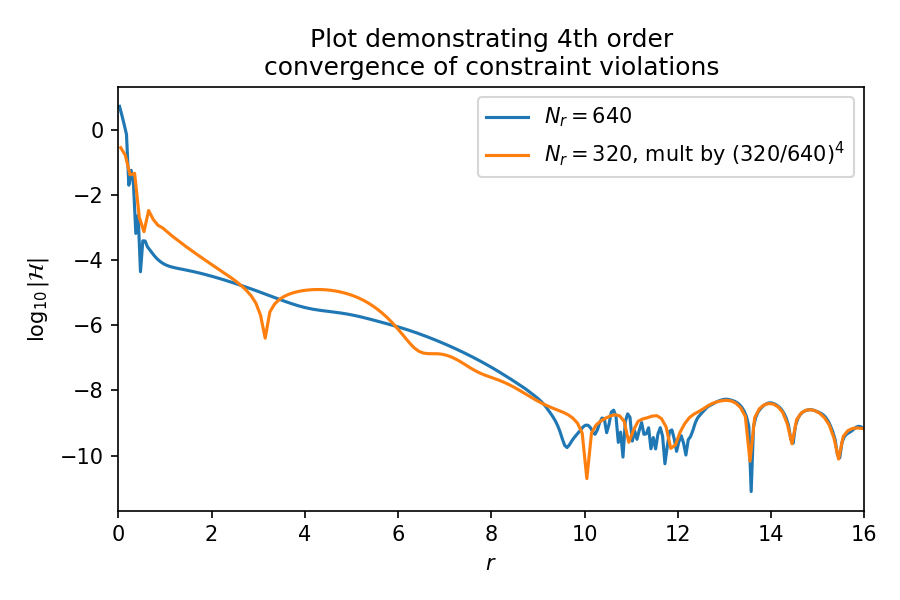

In [20]:
from IPython.display import Image

os.chdir(outdir)

cmd.delete_existing_files("out320*.txt")
cmd.Execute("ScalarFieldCollapse_Playground", "320 2 2 "+str(CFL_FACTOR),"out320.txt")

os.chdir(os.path.join("..",".."))

outfig = os.path.join(outdir,"ScalarFieldCollapse_H_convergence.png")

fig = plt.figure()

r_640,H_640 = np.loadtxt(os.path.join(outdir,"out640.txt")).T
r_320,H_320 = np.loadtxt(os.path.join(outdir,"out320.txt")).T

plt.title("Plot demonstrating 4th order\nconvergence of constraint violations")
plt.xlabel(r"$r$")
plt.ylabel(r"$\log_{10}|\mathcal{H}|$")
plt.xlim(0,16)
plt.plot(r_640,H_640,label=r"$N_{r} = 640$")
plt.plot(r_320,H_320+4*np.log10(320.0/640.0),label=r"$N_{r} = 320$, mult by $(320/640)^{4}$")
plt.legend()

plt.tight_layout()
plt.savefig(outfig,dpi=150)
plt.close(fig)
Image(outfig)

<a id='output_to_pdf'></a>

# Step 8: Output this module as $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{output_to_pdf}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-BSSNCurvilinear-ScalarField_Collapse.pdf](Tutorial-Start_to_Finish-BSSNCurvilinear-ScalarField_Collapse.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [21]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-BSSNCurvilinear-ScalarField_Collapse")

Created Tutorial-Start_to_Finish-BSSNCurvilinear-ScalarField_Collapse.tex,
    and compiled LaTeX file to PDF file Tutorial-Start_to_Finish-
    BSSNCurvilinear-ScalarField_Collapse.pdf
